

```
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)
```



# To do

Ablation tests in notebook

# Starter code

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# In case of OSError: [Errno 107] Transport endpoint is not connected, restart Kernel

FOLDERNAME = 'Depth_Estimation'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


# this changes the working directory to the folder, and allows us to perform version control operations
%cd drive/My\ Drive/$FOLDERNAME
!git config --global user.email "arjun2000ashok@gmail.com"
!git config --global user.name "Arjun Ashok"



import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)

import numpy as np
np.random.seed(0)

from PIL import Image
from io import BytesIO
%matplotlib inline

%load_ext autoreload
%autoreload 2
!pip install wandb -qq
import wandb
!wandb login

# Evaluate on complete validation set

Get the model file(either the last epoch or the best test or both), run a test on the complete validation set, get metrics,loss etc.

After this,

1. Train more, if needed
2. Test on the test set
3. Architecture search, transfer learning mode switch, ablation tests(arc 1,2,3,.. w/wout transfer learning on different test sets
4. KITTI training - if time permits

In [ ]:
# do not click this cell again

from model.net import DenseDepth
from model.dataloader import DataLoaders
from utils import *
from evaluate import *

dataloaders = DataLoaders('nyu_data.zip')

In [ ]:
checkpoint_file = 'epoch_13.pth.tar'

wandb.init(id="kaggle_script_test_5", project="depth_estimation", resume='allow') # we will not watching the model for now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = DenseDepth(); model = model.to(device)
print('Loading checkpoint from cloud storage:',checkpoint_file)
load_checkpoint(wandb.restore(checkpoint_file).name, model)
print('Loaded checkpoint from cloud storage:',checkpoint_file) 
test_metrics_collection = []

In [ ]:
config = {'test_batch_size': 1, 'test_metrics_log_interval': 50}
loss, metrics = evaluate_full(model, dataloaders.get_val_dataloader, config)
test_metrics_collection.append({'config': config, 'loss': loss, 'metrics': metrics})

# Single image evaluate code

In [ ]:
# run the previous cells before running this cell (model loading, dataloader, config)
batch_size = 2
test_images, test_depths, test_preds, test_loss, test_metrics = evaluate(model, dataloaders.get_val_dataloader, batch_size)

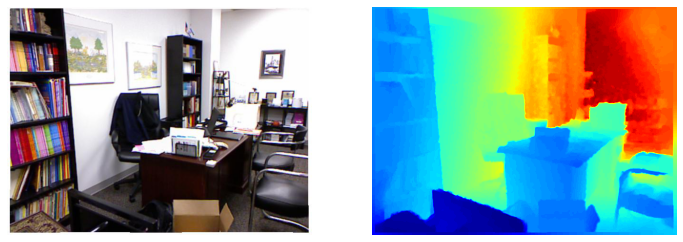

In [ ]:
plot_sample_tensor(test_images[1], test_depths[1])

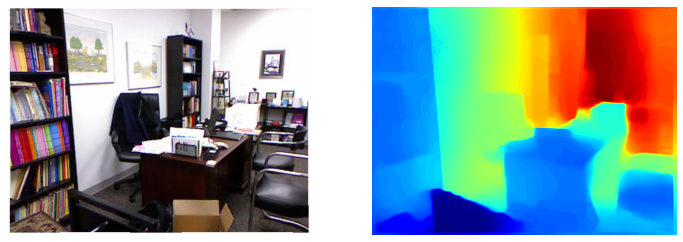

In [ ]:
plot_sample_tensor(test_images[1], test_preds[1])

# Git commit and push

In [ ]:
# !git reset --soft HEAD~1 # UNDO PREVIOUS COMMIT AND PUT THOSE FILES IN STAGING AREA
# !git status # - VIEW STAGED, UNTRACKED FILES
# !git reset HEAD -- . # - TO UNSTAGE FILES
# !git log # LOG

In [ ]:
# !git add .
# !git commit -m 'Added full val set evaluate code, added visualize code'
# !git push -u origin master

[master e07b581] Added full val set evaluate code, added visualize code
 7 files changed, 83 insertions(+), 101 deletions(-)
 rewrite Depth Estimation.ipynb (94%)
 rewrite __pycache__/evaluate.cpython-36.pyc (77%)
 delete mode 100644 test.py
Counting objects: 11, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (11/11), done.
Writing objects: 100% (11/11), 287.11 KiB | 8.20 MiB/s, done.
Total 11 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/aiarjun/Monocular-Depth-Estimation.git
   e47f19e..e07b581  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.


In [ ]:
# !git pull

remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 42 (delta 28), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.
From https://github.com/aiarjun/Monocular-Depth-Estimation
   d2a4796..e47f19e  master     -> origin/master
Updating d2a4796..e47f19e
Fast-forward
 train.py | 41 +++++++++++++++++++++++++++++++----------
 utils.py | 13 ++++++++++---
 2 files changed, 41 insertions(+), 13 deletions(-)


# Exploring the test.zip

In [2]:
from zipfile import ZipFile
def get_zip_file(path):
    input_zip = ZipFile(path)
    data = {name: input_zip.read(name) for name in input_zip.namelist()}
    return data 

data = get_zip_file('nyu_test.zip')

In [3]:
from io import BytesIO

rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
depth = np.load(BytesIO(data['eigen_test_depth.npy']))
crop = np.load(BytesIO(data['eigen_test_crop.npy']))

In [13]:
from utils import *

sample_rgb = rgb[3]
sample_depth = depth[3]
sample_depth = np.clip(sample_depth, 1.0, 10.0) / 10 * 255
print(sample_depth.shape)
# print(sample_depth.min(), sample_depth.max())
# img = Image.fromarray(sample_rgb.astype(np.uint8), mode = 'RGB')
# img_depth = Image.fromarray(sample_depth.astype(np.uint8)[:,:], mode='L')
# plot_sample_image(img, img_depth)

(480, 640)


In [3]:
from model.dataloader import get_test_data
samples, crop = get_test_data('nyu_test.zip')